In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import re
import ipywidgets as widgets
from util.util import get_options_from_file, ewma_halflife
import os
from torch.nn import MSELoss
from skimage.metrics import mean_squared_error
mse = MSELoss()
modelBase = Path('checkpoints')
val_log_file = 'val_loss_log.csv'
models = list(modelBase.rglob(val_log_file))
testResBase = Path('results')


def getPatNameAndImNum(imFileName):
    imFileName = str(imFileName)
    rgx = re.compile('\d{1}_\d{3}|PAT\d{4}_\d{1}')
    patName = rgx.match(imFileName)[0]
    imNum = imFileName.replace(patName, '').replace('fake_B.npy', '').replace('real_B.npy', '').replace('_','')
    return patName, imNum

##  Validation loss over time

In [64]:
# Select model to inspect validation loss
strModels = [str(mdl.parts[-2]) for mdl in models]
selectedModel = widgets.Dropdown(
    options=strModels,
    value=strModels[0],
    description='Model name:',
    disabled=False,
    layout = {'width' : 'initial'}
)
selectedModel

Dropdown(description='Model name:', layout=Layout(width='initial'), options=('npyArray16bitValSetResNetBackend…

In [69]:
optDict = get_options_from_file(modelBase / selectedModel.value / 'train_opt.txt')
trainSize, valSize, testSize = [len(list((path / 'A').glob('*'))) for path in [Path(optDict['dataroot']) / elem for elem in ['train', 'val', 'test']]]

In [70]:
val_log = pd.read_csv(modelBase / selectedModel.value / val_log_file)
val_log.head()
val_log['epochs'] = val_log.iters / trainSize

In [71]:
val_log.sort_values('val_loss', ascending=True).head()

,time,epoch,iters,val_loss,val_std,epochs
6,Fri Apr 16 14:59:13 2021,15,14000,0.039932,0.017165,14.155713
24,Fri Apr 16 15:37:00 2021,51,50000,0.040979,0.018455,50.556117
41,Fri Apr 16 16:12:59 2021,85,84000,0.041394,0.018400,84.934277
46,Fri Apr 16 16:23:34 2021,96,94000,0.041405,0.019186,95.045501
36,Fri Apr 16 16:02:21 2021,75,74000,0.041460,0.017928,74.823054


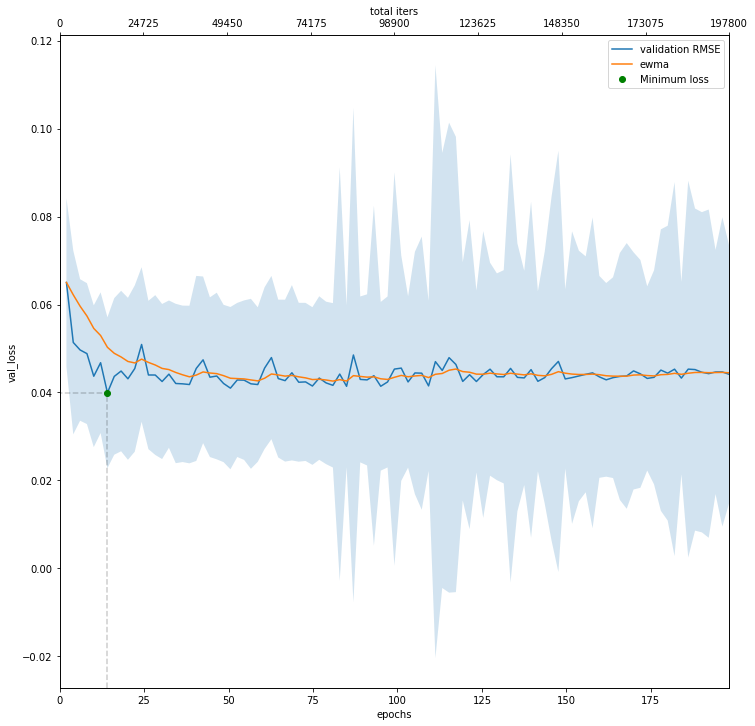

In [72]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)
x1, x2 = 'epochs', 'iters'
sns.lineplot(x=x1, y='val_loss', data=val_log, label='validation RMSE', ax = ax1)
plt.fill_between(val_log[x1], val_log.val_loss - val_log.val_std, val_log.val_loss + val_log.val_std, alpha = .2)
halflife = 3
plt.plot(val_log[x1], ewma_halflife(val_log.val_loss, halflife), label = 'ewma')

min_row = val_log.sort_values('val_loss', ascending=True).iloc[[0], :]
# sns.scatterplot(min_row.epochs, min_row.val_loss, ax=ax1)
plt.plot(min_row.epochs, min_row.val_loss, 'go', label = 'Minimum loss')

plt.legend()
xlim, ylim = ax1.get_xlim(), ax1.get_ylim()
plt.vlines(min_row.epochs.values[0], ylim[0], min_row.val_loss.values[0], linestyles = 'dashed', alpha = .2)
plt.hlines(min_row.val_loss.values[0], xlim[0], min_row.epochs.values[0], linestyles = 'dashed', alpha = .2)
plt.xlim((0, np.max(val_log[x1])))
plt.ylim(ylim)

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(ax1.get_xticks()*trainSize)
ax2.set_xlabel('total iters');



## Test set RMSE loss

In [80]:
testModels = list(testResBase.glob('*/*'))
testModels = [model for model in testModels if 'npyImages' in os.listdir(model)]

selectedTestModels = widgets.SelectMultiple(
    options=testModels,
    rows=20,
    description='Models',
    disabled=False,
    layout = {'width' : 'initial'}
)
selectedTestModels

SelectMultiple(description='Models', layout=Layout(width='initial'), options=(PosixPath('results/npyArray16bit…

In [81]:
row_list = []
for model in selectedTestModels.value:
    print(model)
    fake_B_images = list(model.glob('npyImages/*fake_B.npy'))
    real_B_images = list(model.glob('npyImages/*real_B.npy'))
    fake_B_images.sort()
    real_B_images.sort()
    # real and fake images should be corresponding now
    for fake_im, real_im in zip(fake_B_images, real_B_images):
        patName, imageNumber = getPatNameAndImNum(fake_im.name)
        real_im_npy = np.load(real_im)[0]
        fake_im_npy = np.load(fake_im)[0]
        error_im = real_im_npy - fake_im_npy

        row_list.append(
            {
                'Model' : str(model.parts[1]),
                'epoch' : str(model.parts[2]).replace('test_', ''),
                'Patient' : patName,
                'ImageNumber' : imageNumber,
                'RMSE' : np.sqrt(np.mean(error_im)**2 + np.std(error_im)**2),
                # 'skimage_RMSE' : np.sqrt(mean_squared_error(real_im_npy, fake_im_npy))
            }
        )

results/npyArray16bitValSetResNetBackendCleanDSOutputNc1Flip/test_60
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1Flip/test_15
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1Flip/test_25
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1Flip/test_200
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1Flip/test_50
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1Flip/test_20
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1Flip/test_30
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1Flip/test_40
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1/test_160
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1/test_110
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1/test_100
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1/test_150
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1/test_130
results/npyArray16bitValSetResNetBackendCleanDSOutputNc1/test_200
results/npyArray16bitValSetResNetBackendCleanDSOutp

In [82]:
df = pd.DataFrame(row_list)
df.Patient = df.Patient.astype('category')
df

,Model,epoch,Patient,ImageNumber,RMSE
0,npyArray16bitValSetResNetBackendCleanDSOutputN...,60,2_010,000,0.068385
1,npyArray16bitValSetResNetBackendCleanDSOutputN...,60,2_010,001,0.064201
2,npyArray16bitValSetResNetBackendCleanDSOutputN...,60,2_010,002,0.061212
3,npyArray16bitValSetResNetBackendCleanDSOutputN...,60,2_010,003,0.057130
4,npyArray16bitValSetResNetBackendCleanDSOutputN...,60,2_010,004,0.051465
...,...,...,...,...,...
7371,npyArray16bitValSetResNetBackendCleanDSOutputNc1,120,3_053,178,0.066183
7372,npyArray16bitValSetResNetBackendCleanDSOutputNc1,120,3_053,179,0.069047
7373,npyArray16bitValSetResNetBackendCleanDSOutputNc1,120,3_053,180,0.069601
7374,npyArray16bitValSetResNetBackendCleanDSOutputNc1,120,3_053,181,0.062785


In [83]:
df.epoch = df.epoch.astype(int)

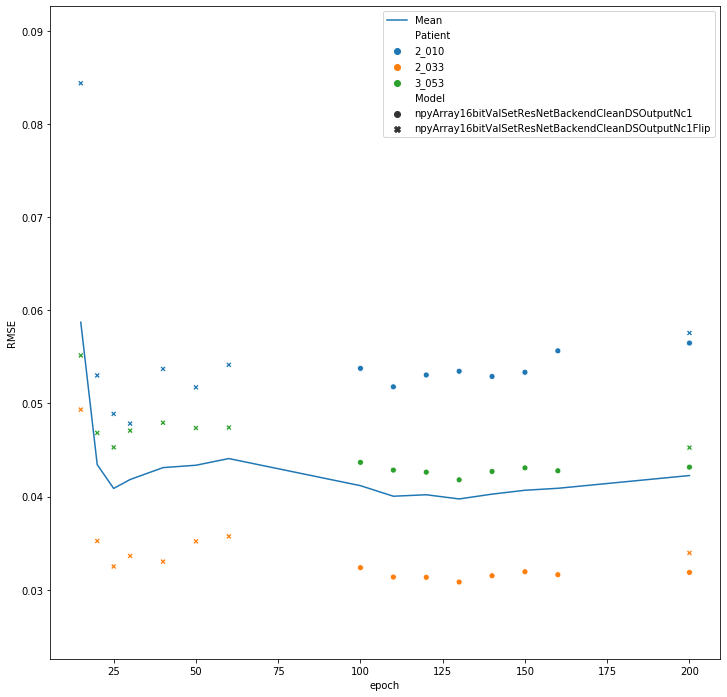

In [84]:
plt.figure(figsize = (12,12))
sns.scatterplot(data = df.groupby(['Patient', 'epoch' , 'Model']).mean().reset_index(), x = 'epoch', y = 'RMSE', hue = 'Patient', style = 'Model')
sns.lineplot(data = df.groupby(['epoch']).mean().reset_index(), x = 'epoch', y = 'RMSE', label = 'Mean')


In [85]:
df.groupby(['Model', 'epoch']).mean()

RMSE
Model                                              epoch          
npyArray16bitValSetResNetBackendCleanDSOutputNc1   100    0.041179
                                                   110    0.040045
                                                   120    0.040203
                                                   130    0.039754
                                                   140    0.040270
                                                   150    0.040686
                                                   160    0.040897
                                                   200    0.041321
npyArray16bitValSetResNetBackendCleanDSOutputNc... 15     0.058720
                                                   20     0.043431
                                                   25     0.040883
                                                   30     0.041840
                                                   40     0.043116
                                                   50     0.043372
                                                   60     0.044088
                                                   200    0.043211

In [87]:
pd.DataFrame(row_list).groupby(['Patient','Model','epoch']).mean().reset_index()

,Patient,Model,epoch,RMSE
0,2_010,npyArray16bitValSetResNetBackendCleanDSOutputNc1,100,0.053773
1,2_010,npyArray16bitValSetResNetBackendCleanDSOutputNc1,110,0.051789
2,2_010,npyArray16bitValSetResNetBackendCleanDSOutputNc1,120,0.053058
3,2_010,npyArray16bitValSetResNetBackendCleanDSOutputNc1,130,0.053461
4,2_010,npyArray16bitValSetResNetBackendCleanDSOutputNc1,140,0.052901
5,2_010,npyArray16bitValSetResNetBackendCleanDSOutputNc1,150,0.053352
6,2_010,npyArray16bitValSetResNetBackendCleanDSOutputNc1,160,0.055652
7,2_010,npyArray16bitValSetResNetBackendCleanDSOutputNc1,200,0.056489
8,2_010,npyArray16bitValSetResNetBackendCleanDSOutputN...,15,0.084377
9,2_010,npyArray16bitValSetResNetBackendCleanDSOutputN...,20,0.053013


In [101]:
index = 300
test_im_fake = np.load(fake_B_images[index]).astype(np.float32)
test_im_real  = np.load(real_B_images[index]).astype(np.float32)

In [102]:
test_im_fake.shape

(1, 256, 256)

(-0.5, 255.5, 255.5, -0.5)

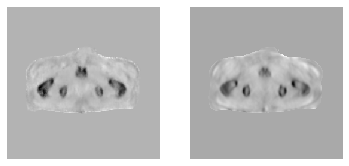

In [103]:
plt.subplot(121)
plt.imshow(test_im_fake[0], cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(test_im_real[0], cmap ='gray')
plt.axis('off')

In [114]:
testStrs = ['2_011_7_fake_B.npy' , 'PAT1056_1_100_fake_B.npy']

[rgx.match(elem)[0] for elem in testStrs]

['2_011', 'PAT1056_1']

In [115]:
getPatNameAndImNum(testStrs[1])

('PAT1056_1', '100')